# Домашнее задание №1
Выполнили студенты группы 154: Алиев М.А. Потехин С.А. Кугушева А.С.

## Предобработка данных

Для загрузки данных из файлов было решено использовать *pandas*, так как он предоставляет множество удобных инструментов для манипуляции данными из коробки.

In [88]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings('ignore')

In [90]:
# reading data from files
data = pd.read_csv('eurlex_data.txt', sep=',', header=None, encoding='utf-8', names=['id', 'text'])
labels = pd.read_csv('eurlex_labels.txt', sep=' ', header=None, names=['label', 'text_id'], usecols=[0, 1])

После беглого осмотра предоставленных текстов становится ясно, что они находятся в практически готовом для обработки состоянии и не требуется проводить лемматизацию или стемминг, тем более что используется далеко не 1 язык, что сильно осложнило бы задачу.

Тексты в файле data пронумерованы непоследовательно, поэтому создадим для них новые id.
С тегами этих текстов немного сложнее, т.к как id, так и тэги в столбцах могут повторяться. К счастью *pandas* позволяет определить уникальные значения для столбца. Воспользовавшись этой функцией найдем все уникальные тэги и пронумеруем.
При этом создадим словари, отображающие тэг/id текста в их порядковый номер. Это понадобится нам в дальнейшнем.

In [3]:
# doing some util staff
# numering every label and text_id
labels_unique = labels['label'].unique()
labels_dict = dict(zip(labels_unique, np.arange(labels_unique.size)))
ids_unique = labels['text_id'].unique()
ids_dict = dict(zip(ids_unique, np.arange(ids_unique.size)))

Задачей является multi-label classification, поэтому ответом для объекта(текста в нашем случае) будет являться индикаторный вектор, где на i-ой позиции будет стоять 1, если текст помечен тэгом под номером i.
Запишем для каждого текста координаты, по которым потом потом будут созданы соответствующие вектора.

In [4]:
# collecting indices of i,j for label matrix
i_indices, j_indices = [], []
for _, row in labels.iterrows():
    i_indices.append(ids_dict[row['text_id']])
    j_indices.append(labels_dict[row['label']])

Имея все координаты, с помощью *scipy* мы можем создать матрицу сразу для всех текстов. Ее размерность - (samples_count, labels_count).

In [93]:
print ('Samples count - {}, labels count - {}'.format(len(data), labels_unique.size))

Samples count - 19348, labels count - 3956


In [5]:
labels_matrix = coo_matrix(
    (np.ones(len(labels)), (i_indices, j_indices)),
    (len(data), labels_unique.size),
    dtype=np.dtype(np.uint8)
).toarray()

Так как каждый текст имеем в среднем 5 тэгов, логично использовать разряженную матрицу, чтобы сэкономить место в памяти, однако, к сожалению, по техническим причинам многие модели sklearn (в том числе и используемая нами MLP) не умеют работать с ними, поэтому было решено оставить обычный массив массивов.

Также было выяснено что довольно много тэгов встречаются всего несколько раз на протяжении всей выборки. Была предпринята попытка убрать все тэги, появляющиеся реже 5, 10, 15 раз. Это сокращало их количество с 3956 до всего 1000-2000, что существенно ускоряло время обучения и работы всех моделей, а также увеличивало PR AUC (в среднем на 10-15% по сравнению с оригинальным вариантом), но пагубно влияло на показатель ROC-AUC (чем больше тэгов убиралось, тем сильнее падал показатель).

Результаты этого тестирования не приведены в этом отчете, так как требуют перезапуска всей работы с параметром freq_threshold.

In [98]:
print ('Average label count for text - {}'.format(labels_matrix.sum(axis=1).mean()))

Average label count for text - 5.3195091643367505


In [6]:
freq_threshold = 0

# get rid of rare labels (less than X texts with this label)
labels_count_col = labels_matrix.sum(axis=0)
labels_matrix = labels_matrix[:, np.where(labels_count_col >= freq_threshold)[0]]

# get rid of texts with 0 labels
labels_count_row = labels_matrix.sum(axis=1)
norm_indice = np.where(labels_count_row > 0)[0]
labels_matrix = labels_matrix[norm_indice]
data = data.iloc[norm_indice]

In [7]:
# storing names of bad (too rare), good labels
# storing new ids for labels after frequency cleanup
bad_labels, good_labels, bad_indice = [], [], np.where(labels_count_col < freq_threshold)[0]
for idx, i in enumerate(labels_unique):
    if idx in bad_indice:
        bad_labels.append(i)
    else:
        good_labels.append(i)
        
# updated labels_dict with correct ids
labels_dict = dict(zip(good_labels, np.arange(len(good_labels))))

С помощью инструментов *sklearn* разобьем выбору на обучающую и тестовую в соотношении 9 к 1, а также токенизируем тексты. Как уже было сказано, они находятся в хорошем состоянии(нету знаков препинания, больших букв, чисел и тд.) и разделения по пробелу достаточно.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_matrix, test_size=0.1)

def tokenize(texts):
    tokenized_texts = []
    for _, row in texts.iterrows():
        text = row['text'][2:-1].split(" ")
        tokenized_texts.append(text)
    return tokenized_texts
        
X_train_tok, X_test_tok = tokenize(X_train), tokenize(X_test)

## Создание признаковых пространств

Перейдем к главному, а именно к созданию признаковых пространств. Для этой цели были выбраны word2vec, fastText, doc2vec, а также тематическое моделирование с помощью LDA, все в реализации *gensim*.
При подборе параметров было уделено внимание размерности выходящих векторов (увелечение размерности со 100 до 250 позволило немного повысить ROC-AUC), а также количеству итераций обучения и минимальному количеству появлений слова (слова игнорировались, если встречались только 1 раз).

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, FastText

# creating and training W2V
model_w2v = Word2Vec(X_train_tok, size=250, workers=10, iter=25, min_count=2)
print ('w2v fitted')

# and other models
model_ft = FastText(X_train_tok, size=250, workers=10, iter=25, min_count=2)
print ('fastText fitted')

documents_train = [TaggedDocument(text[2:-1], [id_]) for id_, text in X_train[['id', 'text']].values]
documents_test = [TaggedDocument(text[2: -1], [id_]) for id_, text in X_test[['id', 'text']].values]
model_d2v = Doc2Vec(documents_train, vector_size=250, workers=10, epochs=25, min_count=2)
print ('d2v fitted')

w2v fitted
fastText fitted
d2v fitted


In [10]:
# topic modelling with lda
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
from gensim.corpora import Dictionary

dictionary = Dictionary(X_train_tok)
# filterring
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_tok]

In [11]:
from gensim.models import LdaMulticore

lda_model = LdaMulticore(bow_corpus, num_topics=y_train.shape[1], id2word=dictionary, passes=10, workers=10)

In [12]:
# extracting words vectors from fastText
ft = dict(zip(model_ft.wv.index2word, model_ft.wv.vectors))
# extracting words vectors from word2vec
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.vectors))

Дабы не обучать модели после каждого перезапуска, они были сериализованы и сохранены.

In [13]:
import pickle

with open('ft.pickle2', 'wb') as f:
    pickle.dump(model_ft, f)
    
with open('w2v.pickle2', 'wb') as f:
    pickle.dump(model_w2v, f)
    
with open('d2v.pickle2', 'wb') as f:
    pickle.dump(model_d2v, f)
    
with open('lda.pickle2', 'wb') as f:
    pickle.dump(lda_model, f)

In [135]:
import pickle

with open('ft.pickle2', 'rb') as f:
    model_ft = pickle.load(f)
    
with open('w2v.pickle2', 'rb') as f:
    model_w2v = pickle.load(f)
    
with open('d2v.pickle2', 'rb') as f:
    model_d2v = pickle.load(f)
    
with open('lda.pickle2', 'rb') as f:
    lda_model = pickle.load(f)

Было создано несколько классов, позволяющих обработать поданные на вход моделям токенизированные тексты: каждому слову в соответствие ставится вектор (из w2v/ft) и затем берется усредненный вектор по всему тексту (в случае d2v, вектор предоставляется сразу для всего текста).

In [15]:
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
class MeanEmbeddingVectorizer(object):
    def __init__(self, word_dict):
        self.word_dict = word_dict
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word_dict.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word_dict[w] for w in words if w in self.word_dict]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class D2VEmbeddingVectorizer(object):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(" ".join(words), epochs=5) for words in X])
    
class BOWEmbeddingVectorizer(object):
    def __init__(self, dictionary):
        self.dictionary = dictionary

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.dictionary.doc2bow(words) for words in X])

## Классификация

В качестве модели классификатора был выбран MultiLayerPerceptron, так как он один из немногих мог справиться с задачей multi-label классификации. Если быть точным, почти все модели sklearn умеют производить много классовую классификацию, однако они делают это по принципу oneVsAll или oneVsOne, что неприемлемо в нашем случае с почти 4 тысячами возможных классов.

На основе [этой](http://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py) и [этой](https://habr.com/post/318970/) статей было проведено сравнение нескольких варинатов настройки MLP, а именно SGD солвера с использованием [момента нестерова](https://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac) и [Adam солвера](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). Методы показали практически одинаковые результаты, однако Adam сходился быстрее и предпочтение было отдано ему.

### MLP

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


MLP_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("MLP classifier", MLPClassifier(
            solver='adam',
            max_iter=300
        ))])
MLP_ft = Pipeline([
    ("fastText vectorizer", MeanEmbeddingVectorizer(ft)),
    ("MLP classifier", MLPClassifier(
            solver='adam',
            max_iter=300
        ))])
MLP_d2v = Pipeline([
    ("doc2vec vectorizer", D2VEmbeddingVectorizer(model_d2v)),
    ("MLP classifier", MLPClassifier(
            solver='adam',
            max_iter=300
        ))])

In [17]:
from sklearn.metrics import roc_auc_score, average_precision_score

def auc_roc(y_test, y_pred):
    res = []
    for tr, i in zip(y_test, y_pred):
        res.append(roc_auc_score(tr, i))
    return np.mean(res, axis=0)

def auc_roc_pr(y_test, y_pred):
    res = []
    for tr, i in zip(y_test, y_pred):
        res.append(average_precision_score(tr, i))
    return np.mean(res, axis=0)

In [18]:
# w2v case
MLP_w2v.fit(X_train_tok, y_train)
y_pred_w2v = MLP_w2v.predict_proba(X_test_tok)

print ('MLP word2vec')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_w2v)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_w2v)))

MLP word2vec
ROC-AUC - 0.9692961504388884
PR-AUC - 0.52753758480359322


Вывод модели и реальные теги:

In [133]:
test_ = MLP_w2v.predict(X_test_tok[:100])
for i in range(100):
    pred_tags = np.where(test_[i] > 0)[0]
    real_tags = np.where(y_test[i] > 0)[0]
    if len(pred_tags) == 0: continue
    print (pred_tags, real_tags)

[ 1626] [ 239  630  703  870 1387]
[ 843 1911] [318 415 502 656 801 843]
[ 1078 1655] [ 477 1078 1290 1798 3221]
[ 92 195 2121] [  92  161  195  702 1062 1486]
[ 3034 3246] [  55  239  254  397  622 1365]
[ 471 1883] [ 471 1920 1969 2098 2099]
[ 589 1183 1242] [ 133  294  589  706  711 1754]
[ 548 2510] [  0 106 154 400 548 549]
[ 4 400 1027] [  4  83 354]
[ 37 81 1060 2542] [  37   43   81 2542 2543]
[ 167 286 1892] [166 167 286 504 543 658]
[ 24 137 2489] [ 24  72 137 166 167 310]
[ 2270 2306 2905 3015 3027] [2270 2306 2905 3015 3027 3055]
[ 750 792 400] [ 61 110 197 200 750 792]
[ 36 187] [  36   80  159  217 1307]
[ 1329 1436] [ 954 1535]
[ 1138 1299] [ 568  622 1138 1183 2082 2486]
[ 333 866 1001] [ 333 2904 3000 3245 3246]
[ 4 400] [400 513 608 621 629 720 721]
[ 1073 2314] [ 105  150  222  529 1833]


In [19]:
# ft case
MLP_ft.fit(X_train_tok, y_train)
y_pred_ft = MLP_ft.predict_proba(X_test_tok)

print ('MLP fastText')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ft)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_ft)))

MLP fastText
ROC-AUC - 0.9701006704920532
PR-AUC - 0.51951183720757637


In [20]:
# d2v case
MLP_d2v.fit(X_train_tok, y_train)
y_pred_d2v = MLP_d2v.predict_proba(X_test_tok)

print ('MLP doc2vec')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_d2v)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_d2v)))

MLP doc2vec
ROC-AUC - 0.9194073169041706
PR-AUC - 0.19198407037494657


In [21]:
# LDA
ev_bow = BOWEmbeddingVectorizer(dictionary)
bow_corpus_test = ev_bow.transform(X_test_tok)

y_pred_lda_raw = [lda_model[bow] for bow in bow_corpus_test]

# transforming to standard form
y_pred_lda = []
for i in y_pred_lda_raw:
    q = np.zeros(len(y_train[0]))
    i = np.array(i)
    q[i[:, 0].astype(int)] = i[:, 1]
    y_pred_lda.append(q)
y_pred_lda = np.array(y_pred_lda)

print ('LDA bow')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_lda)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_lda)))

LDA bow
ROC-AUC - 0.4997429202059216
PR-AUC - 0.001803253220286128


Как видно из результатов, классификация с помощью word2vec и fastText дала практически одинаковые результаты, doc2vec немног отстал, а вот LDA дал результат, соответствующий случайному гаданию, что не сильно удивляет, так как метод использует обучение без учителя.

Далее в качестве классификатора мы попробовали использовать самодельную нейронную сеть, созданную с помощью 
фреймворка Keras.

### Keras neural network

In [22]:
mwe_w2v = MeanEmbeddingVectorizer(w2v)
mwe_ft = MeanEmbeddingVectorizer(ft)
mwe_d2v = D2VEmbeddingVectorizer(model_d2v)

X_train2 = mwe_w2v.transform(X_train_tok)
X_test2 = mwe_w2v.transform(X_test_tok)

X_train3 = mwe_ft.transform(X_train_tok)
X_test3 = mwe_ft.transform(X_test_tok)

X_train4 = mwe_d2v.transform(X_train_tok)
X_test4 = mwe_d2v.transform(X_test_tok)

In [23]:
#keras var
#https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam


model = Sequential()
model.add(Dense(2000, activation='relu', input_dim=X_train2.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

adam = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam)

Using TensorFlow backend.


In [24]:
model.fit(X_train2, y_train, epochs=300, batch_size=512, verbose=1)
y_pred_ker2 = model.predict(X_test2)

print ('Keras neural network(w2v)')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ker2)))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, y_pred_ker2)))

Epoch 1/300
17382/17382 [==============================] - 5s 297us/step - loss: 40.3003
Epoch 2/300
17382/17382 [==============================] - 5s 260us/step - loss: 38.2385
Epoch 3/300
17382/17382 [==============================] - 4s 258us/step - loss: 37.7057
Epoch 4/300
17382/17382 [==============================] - 4s 257us/step - loss: 37.1191
Epoch 5/300
17382/17382 [==============================] - 4s 257us/step - loss: 36.6309
Epoch 6/300
17382/17382 [==============================] - 4s 257us/step - loss: 36.2760
Epoch 7/300
17382/17382 [==============================] - 4s 258us/step - loss: 35.9507
Epoch 8/300
17382/17382 [==============================] - 4s 257us/step - loss: 35.7113
Epoch 9/300
17382/17382 [==============================] - 4s 258us/step - loss: 35.4644
Epoch 10/300
17382/17382 [==============================] - 4s 258us/step - loss: 35.2376
Epoch 11/300
17382/17382 [==============================] - 5s 259us/step - loss: 34.9877
Epoch 12/300
17382/

In [25]:
model.fit(X_train3, y_train, epochs=300, batch_size=512, verbose=1)
y_pred_ker3 = model.predict(X_test3)

print ('Keras neural network(ft)')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ker3)))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, y_pred_ker3)))

Epoch 1/300
17382/17382 [==============================] - 5s 271us/step - loss: 44.9317
Epoch 2/300
17382/17382 [==============================] - 5s 267us/step - loss: 41.5063
Epoch 3/300
17382/17382 [==============================] - 5s 267us/step - loss: 39.9342
Epoch 4/300
17382/17382 [==============================] - 5s 267us/step - loss: 39.1829
Epoch 5/300
17382/17382 [==============================] - 5s 267us/step - loss: 38.5729
Epoch 6/300
17382/17382 [==============================] - 5s 267us/step - loss: 38.1771
Epoch 7/300
17382/17382 [==============================] - 5s 269us/step - loss: 37.8631
Epoch 8/300
17382/17382 [==============================] - 5s 268us/step - loss: 37.5129
Epoch 9/300
17382/17382 [==============================] - 5s 268us/step - loss: 37.2268
Epoch 10/300
17382/17382 [==============================] - 5s 267us/step - loss: 36.9679
Epoch 11/300
17382/17382 [==============================] - 5s 268us/step - loss: 36.7262
Epoch 12/300
17382/

In [26]:
model.fit(X_train4, y_train, epochs=300, batch_size=512, verbose=1)
y_pred_ker4 = model.predict(X_test4)

print ('Keras neural network(d2v)')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ker4)))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, y_pred_ker4)))

Epoch 1/300
17382/17382 [==============================] - 4s 245us/step - loss: 42.4086
Epoch 2/300
17382/17382 [==============================] - 4s 242us/step - loss: 40.0478
Epoch 3/300
17382/17382 [==============================] - 4s 244us/step - loss: 39.1425
Epoch 4/300
17382/17382 [==============================] - 4s 243us/step - loss: 38.6587
Epoch 5/300
17382/17382 [==============================] - 4s 244us/step - loss: 38.3452
Epoch 6/300
17382/17382 [==============================] - 4s 243us/step - loss: 38.1450
Epoch 7/300
17382/17382 [==============================] - 4s 243us/step - loss: 37.9504
Epoch 8/300
17382/17382 [==============================] - 4s 243us/step - loss: 37.7460
Epoch 9/300
17382/17382 [==============================] - 4s 242us/step - loss: 37.5928
Epoch 10/300
17382/17382 [==============================] - 4s 242us/step - loss: 37.4399
Epoch 11/300
17382/17382 [==============================] - 4s 244us/step - loss: 37.3206
Epoch 12/300
17382/

Результаты сильно уступают по кач-ву MLP в плане PR AUC.

Также был использован KNearestNeighbours(на модели word2vec), адаптированный под задачу multi-label классификации.

### Multi-label kNN

In [27]:
from skmultilearn.adapt import MLkNN


classifier = MLkNN(k=5)

# train
classifier.fit(X_train2, y_train)

MLkNN(ignore_first_neighbours=0, k=5, s=1.0)

In [28]:
# predict
predictions = classifier.predict_proba(X_test2)
print ('ROC-AUC - {}'.format(auc_roc(y_test, predictions.toarray())))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, predictions.toarray())))

ROC-AUC - 0.8703663900203962
PR AUC - 0.05861221203057404


Схожий с Keras NN ROC-AUC, но более низкий PR AUC.

Последним классификатором для проверки является FastText. Ранее я уже пользовался им, но это была реализация от *gensim* и использовалась она для создания признаков. Теперь же попробуем воспользоваться полноценной версией инструмента.

### FastText

Инструмент требует специфического формата данных для обучения, поэтому нужно создать соответствующий файл.

In [29]:
# fast text util
from csv import reader
import csv
csv.field_size_limit(100000000)

PATH = {
    "data" : "eurlex_data.txt",
    "labels" : "eurlex_labels.txt"
}

data = {}

# Read data
with open(PATH["data"]) as ff:
    r = reader(ff)
    for row in r:
        i, s = row
        s = s.strip()[1:-1] # Remove quotes
        data[int(i)] = {
            "s" : s,
            "labels" : []
        }

# Merge labels into data
with open(PATH["labels"]) as ff:
    r = reader(ff)
    for row in r:
        label, data_index, _ = row[0].split()
        if label in good_labels:
            data[int(data_index)]["labels"].append(label)
        
# Save the data into the file
lable_mask = "__label__{} "
FILE = "hw_fasttext.txt"

with open(FILE, "w") as ff:
    for i,d in data.items():
        s = ""
        if len(d["labels"]) == 0: continue
            
        for l in d["labels"]:
            s += lable_mask.format(l)

        s += d["s"]
        ff.write(s + "\n")

In [30]:
# training
from fastText import train_supervised

model = train_supervised(
    input=FILE, epoch=25, lr=0.1, verbose=2, minCount=2
)

Ответ модель выдает также в своем собственном формате. Приведем его к более стандартному, чтобы проверить нужные метрики.

In [108]:
# predicting
# k = 5, beacuse average text has 5 labels
y_pred_raw = model.predict([" ".join(i) for i in X_test_tok], k=3956)

# transforming labels into ids
labels_all = []
for i in y_pred_raw[0]:
    label_row = []
    for label in i:
        label = labels_dict[label[9:]]
        label_row.append(label)
    labels_all.append(np.array(label_row))
    
# transforming result to standard form
y_pred_res = []
for idx, i in enumerate(labels_all):
    q = np.zeros(y_train.shape[1])
    i = np.array(i)
    q[i] = y_pred_raw[1][idx]
    y_pred_res.append(q)
y_pred_res = np.array(y_pred_res)
# y_pred_res = y_pred_res[:, :1560]

In [110]:
print ('Clear FastText')
print (auc_roc(y_test, y_pred_res))
print (auc_roc_pr(y_test, y_pred_res))

Clear FastText
0.8291624373243002
0.06688142316245543


Результаты неплохие, но хуже, чем у вариантов с нейронными сетями.

## Visualization

Для возможности визуализации, размерность данных нужно, очевидно, понизить. В качестве инструментов были использованы TSNE и PCA в реализации *sklearn*. Графики строились с помощью plotly: 2D и 3D версия для каждой из проверенных моделей, а именно TSNE+W2V, TSNE+FT, PCA+W2V, PCA+FT, итого 8 графиков.

In [147]:
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go

# visualizing
# https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model=None, new_values=[], count=100, annotate=True, dim=2):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i, word in enumerate(model.wv.vocab):
        if len(new_values) == 0:
            tokens.append(model[word])
        if annotate:
            labels.append(word)
        if i == count: break
    
    if len(new_values) == 0:
        tsne_model = TSNE(perplexity=50, learning_rate=400, n_components=dim, init='pca', n_iter=1000)
        new_values = tsne_model.fit_transform(tokens)
        
    new_values = new_values[:count]
    x = []
    y = []
    z = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        if dim == 3:
            z.append(value[2])
        
    if dim == 2:
        trace = go.Scattergl(
            x = np.array(x),
            y = np.array(y),
            mode = 'markers',
            text=labels,
            marker = dict(
                color = '#0c9e9e',
                line = dict(width = 1),
                size=7
            )
        )
        plt.figure(figsize=(16, 16)) 
        plt.grid(True)
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            if annotate:
                plt.annotate(labels[i],
                             xy=(x[i], y[i]),
                             xytext=(5, 2),
                             textcoords='offset points',
                             ha='right',
                             va='bottom')
    else:
        trace = go.Scatter3d(
            x = x,
            y = y,
            z = z,
            mode='markers',
            text=labels,
            marker=dict(line={'width':1}, size=5)
        )
    data = [trace]
    return data

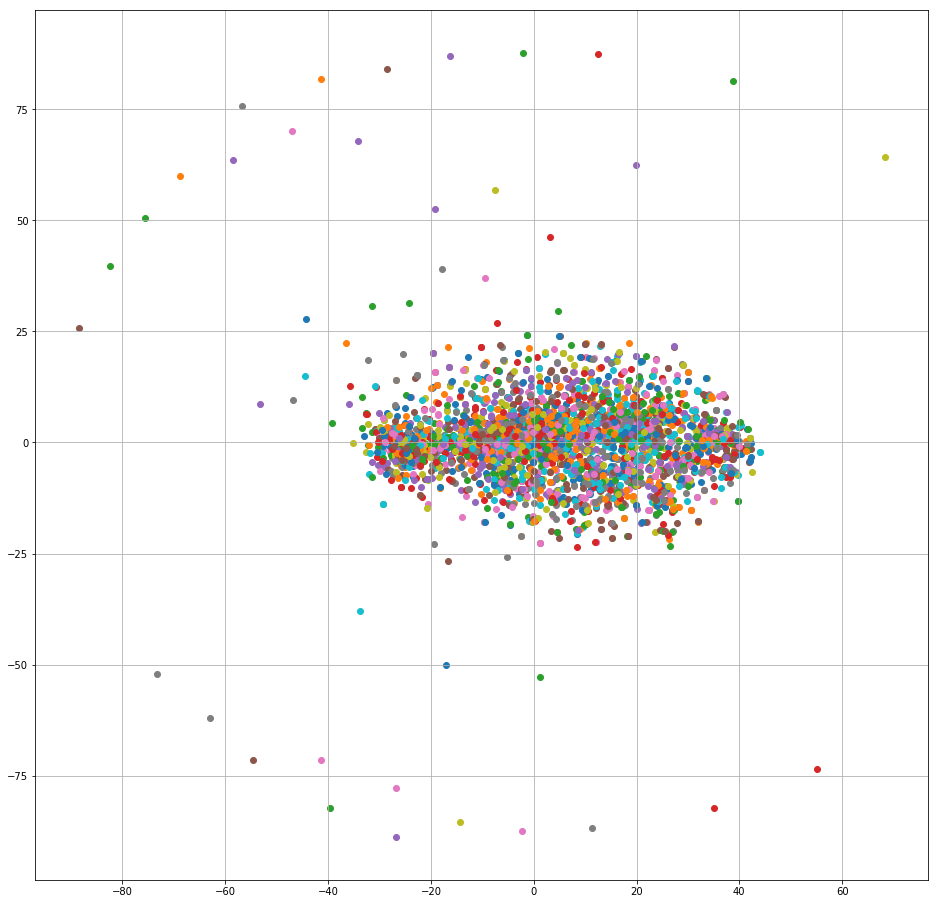

In [148]:
# w2v t-sne 2d
data = tsne_plot(model=model_w2v, count=3000, annotate=False)
# py.iplot(data, filename='w2v t-sne 2d')

ссылка на интерактивный график -> https://plot.ly/~30mb1/14/

In [ ]:
# w2v t-sne 3d
# data = tsne_plot(model=model_w2v, count=2000, dim=3)
# py.iplot(data, filename='w2v t-sne 3d')

ссылка на интерактивный график (3D)-> https://plot.ly/~30mb1/16/

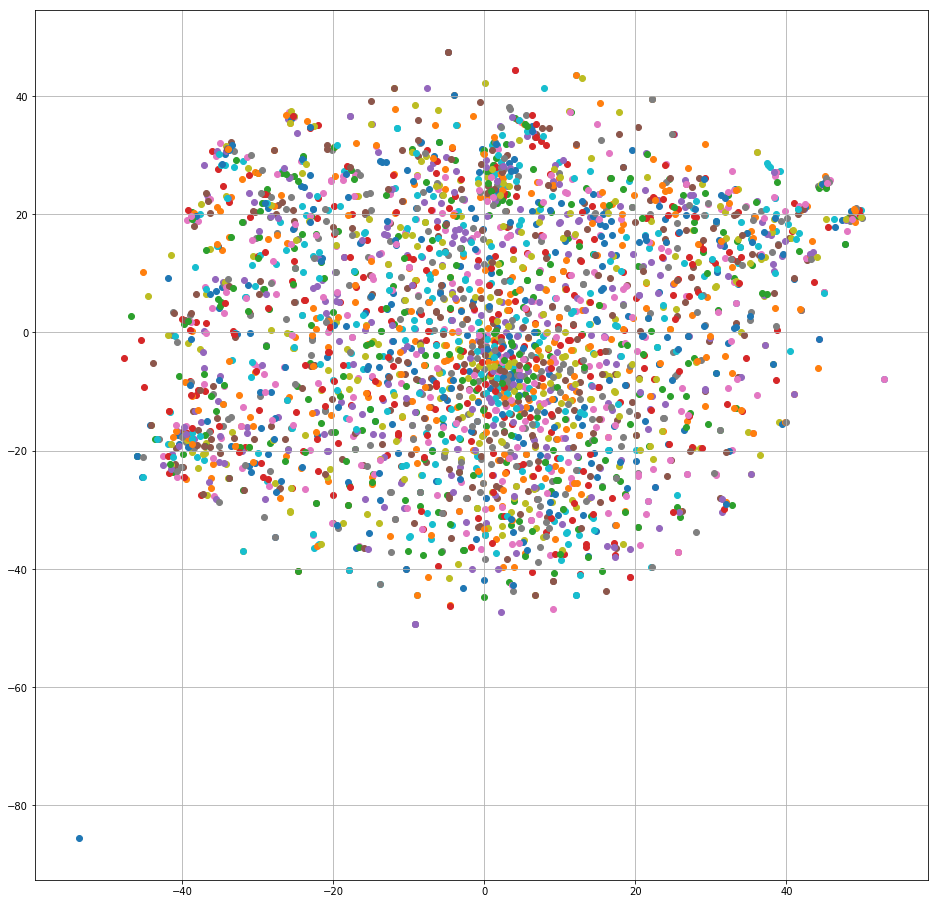

In [149]:
data = tsne_plot(model=model_ft, count=3000, annotate=False)
# py.iplot(data, filename='ft t-sne 2d')

ссылка на интерактивный график -> https://plot.ly/~30mb1/18/

In [ ]:
# data = tsne_plot(model=model_ft, count=2000, dim=3)
# py.iplot(data, filename='ft t-sne 3d')

ссылка на интерактивный график(3D) -> https://plot.ly/~30mb1/20/

На данных размерности 3 отличий нет, однако на 2D графиках видны четкие отличия. У word2vec слова очень плотно сжаты + некоторые слова сильно отдалились от основной массы, в то время как на граике fastText модели данные более разряжены, без выбросов и можно разглядеть несколько кластеров в общей массе.

In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca3 = PCA(n_components=3)

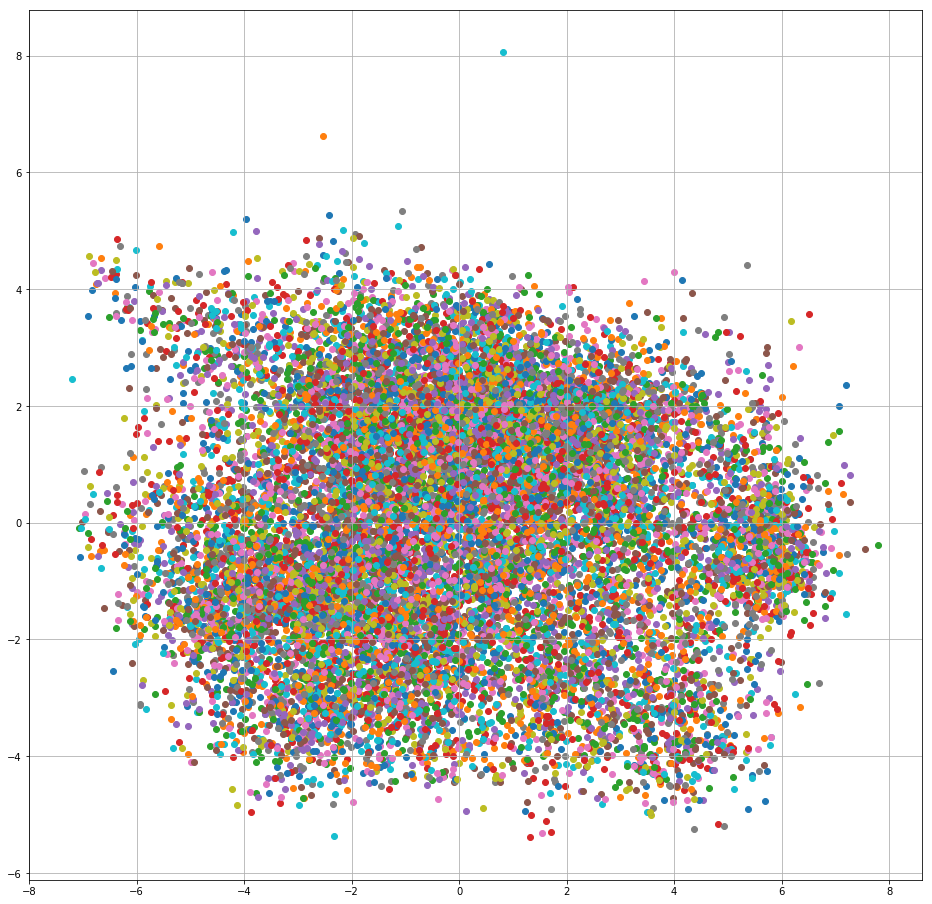

In [150]:
pca.fit(X_train2)
low_d_x = pca.transform(X_train2)

data = tsne_plot(model=model_w2v, new_values=low_d_x, count=len(low_d_x), annotate=False)
# py.iplot(data, filename='w2v pca 2d')

ссылка на интерактивный график -> https://plot.ly/~30mb1/22/

In [146]:
pca3.fit(X_train2)
low_d_x = pca3.transform(X_train2)

# data = tsne_plot(model=model_w2v, new_values=low_d_x, count=len(low_d_x), dim=3)
# py.iplot(data, filename='w2v pca 3d')

ссылка на интерактивный график(3D версия) -> https://plot.ly/~30mb1/24

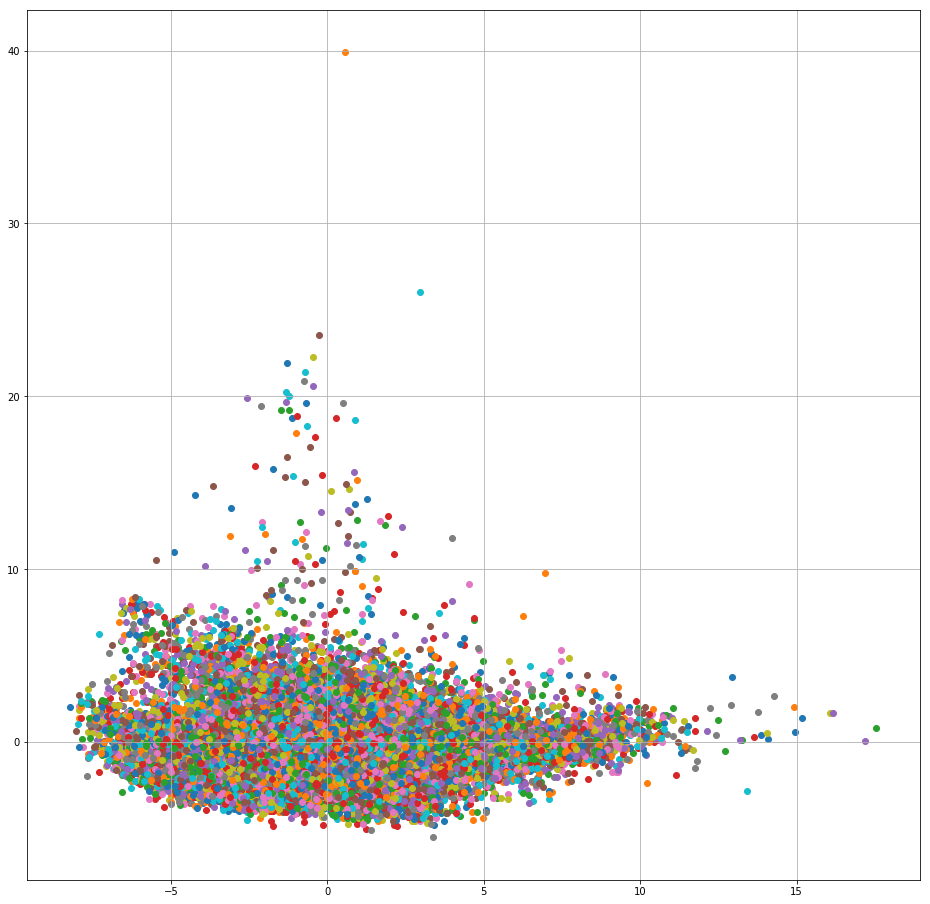

In [151]:
pca.fit(X_train3)
low_d_x = pca.transform(X_train3)

data = tsne_plot(model=model_ft, new_values=low_d_x, count=len(low_d_x), annotate=False)
# py.iplot(data, filename='ft pca 2d')

ссылка на интерактивный график -> https://plot.ly/~30mb1/26

In [143]:
pca3.fit(X_train3)
low_d_x = pca3.transform(X_train3)

# data = tsne_plot(model=model_ft, new_values=low_d_x, count=len(low_d_x), dim=3)
# py.iplot(data, filename='ft pca 3d')

ссылка на интерактивный график(3D версия) -> https://plot.ly/~30mb1/28

В случае с PCA 2D версии не сильно отличаются от своих более высоко-размерных аналогов. На графике модели word2vec распределение похоже на случайное, в то время как на fastText варианте можно проследить некоторую закономерность.
В целом, TSNE дает более информативную визуализацию, т.к PCA может терять много информации про сжатии (все-таки понимажем размерность с 250 до 2-3)

И последним вариантом визуализации является онлайн инструмент от [tensorflow](https://projector.tensorflow.org/). Он позволяет в режиме реального времени отслеживать итерации обучения TSNE, а также настраивать ее. Ниже написан скрипт для подготовки данных для инструмента (требуется TSV формат), а также приведены ссылки, по которым можно увидеть готовые для просмотра версии.

In [84]:
# preparing data for tensorflow projection util

# w2v
tokens, labels = [], []

for i, word in enumerate(model_w2v.wv.vocab):
        tokens.append(model_w2v[word])
        labels.append(word)
        if i == 5000: break
            
with open('w2v.tsv', 'w') as f:
    res = ''
    for tok in tokens:
        res += '\t'.join([str(i) for i in tok]) + '\n'
    f.write(res)

with open('w2v_meta.tsv', 'w') as f:
    res = ''
    for l in labels:
        res += l + '\n'
    f.write(res)
    
# ft
tokens, labels = [], []

for i, word in enumerate(model_ft.wv.vocab):
        tokens.append(model_ft[word])
        labels.append(word)
        if i == 5000: break
            
with open('ft.tsv', 'w') as f:
    res = ''
    for tok in tokens:
        res += '\t'.join([str(i) for i in tok]) + '\n'
    f.write(res)

with open('ft_meta.tsv', 'w') as f:
    res = ''
    for l in labels:
        res += l + '\n'
    f.write(res)

[word2vec embedding visualization](https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/30mb1/320500f5753f2bc41110dac1416a78d6/raw/1c30f014ef92810ba71d896d9dcef4c4f11e1803/projector_config.json)


[fastText embedding visualization](https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/30mb1/427f6269a7d6e2210e34557cb07e45eb/raw/78ea5c28cd7d2e739db46c47d4b86f9220e06c39/projector_config.json)
